<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#20-news-groups-load" data-toc-modified-id="20-news-groups-load-1">20 news groups load</a></span></li><li><span><a href="#Spectral-Clustering" data-toc-modified-id="Spectral-Clustering-2">Spectral Clustering</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-3">PCA</a></span></li><li><span><a href="#SPECTRAL" data-toc-modified-id="SPECTRAL-4">SPECTRAL</a></span></li><li><span><a href="#SPECTRAL-V2" data-toc-modified-id="SPECTRAL-V2-5">SPECTRAL V2</a></span></li><li><span><a href="#3D" data-toc-modified-id="3D-6">3D</a></span></li></ul></div>

# 20 news groups load

In [1]:
import spectral
import scipy
from scipy import sparse
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
sns.set(rc={"figure.figsize": (15, 6)})
sns.set_palette(sns.color_palette("Set2", 10))

from sklearn import preprocessing, decomposition, model_selection

In [2]:
from sklearn import metrics
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
all_news = fetch_20newsgroups(subset='all')

In [4]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, sublinear_tf=True, max_features=500)

In [5]:
news_data = vectorizer.fit_transform(all_news.data)
news_target = all_news.target
news_target_names = all_news.target_names 

feature_names = vectorizer.get_feature_names()

In [6]:
subset_mask = np.random.permutation(len(news_target))[:4000]

X = scipy.sparse.csr_matrix.todense(news_data[subset_mask])
y = news_target[subset_mask]

In [7]:
X.shape, y.shape

((4000, 500), (4000,))

In [8]:
news_target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [9]:
df_targets = pd.DataFrame(news_target_names)

In [10]:
parent_cat = ['comp.', 'rec.', '.politics.', 'sci.', 'misc.forsale', 'religion' ]

parent_cat_ind = []
for c in parent_cat:
    ind = df_targets[df_targets[0].apply(lambda x: c in x).values].index.values
    if c == 'religion':
        ind = np.append(ind, 0)
    parent_cat_ind.append(ind)

In [11]:
parent_cat_ind

[array([1, 2, 3, 4, 5], dtype=int64),
 array([ 7,  8,  9, 10], dtype=int64),
 array([16, 17, 18], dtype=int64),
 array([11, 12, 13, 14], dtype=int64),
 array([6], dtype=int64),
 array([15, 19,  0], dtype=int64)]

In [12]:
def is_in(s):
    return np.vectorize(lambda x: x in s)

In [13]:
set(y)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}

In [14]:
new_y = y.copy()
for i, s in enumerate(parent_cat_ind):
    m = is_in(s)(y)
    print(i, s, m)
    new_y[m] = i
    
y = new_y

0 [1 2 3 4 5] [False False False ..., False  True  True]
1 [ 7  8  9 10] [ True False False ..., False False False]
2 [16 17 18] [False  True  True ..., False False False]
3 [11 12 13 14] [False False False ...,  True False False]
4 [6] [False False False ..., False False False]
5 [15 19  0] [False False False ..., False False False]


In [15]:
set(y)

{0, 1, 2, 3, 4, 5}

In [16]:
y.shape

(4000,)

targets = np.random.permutation(len(news_target_names))

mask = np.zeros_like(news_target, dtype=bool)
label_to_name = {}

for t in targets:
    name = news_target_names[t]
    label_to_name[t] = name
    print(name)
    mask = mask | (news_target == t)

# Spectral Clustering

In [17]:
print(np.count_nonzero(y == np.nan))

0


In [18]:
distances = spectral.features_to_dist_matrix(X, metric='cosine')

if np.count_nonzero(np.isnan(distances)) > 0:
    print('there are some nan')
    distances = np.nan_to_num(distances, copy=False)

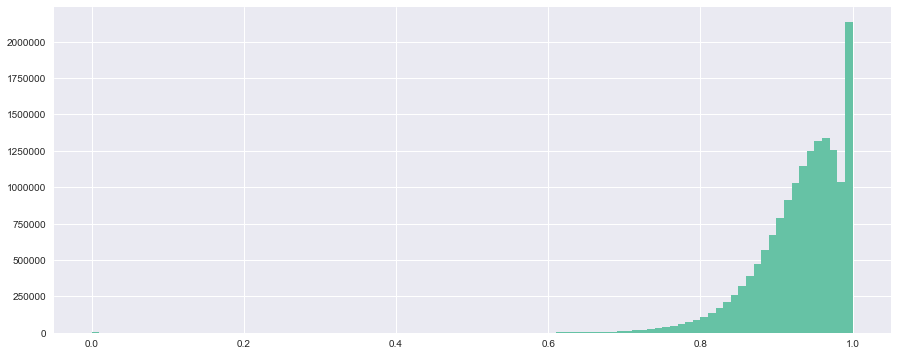

In [19]:
plt.hist(np.nan_to_num(distances, copy=True).flatten(), bins=100);

In [20]:
print('{} distances equal exactly zero.'.format(np.sum(distances == 0)))

4002 distances equal exactly zero.


In [21]:
all_weights = spectral.dist_to_adj_matrix(distances, 'gaussian')

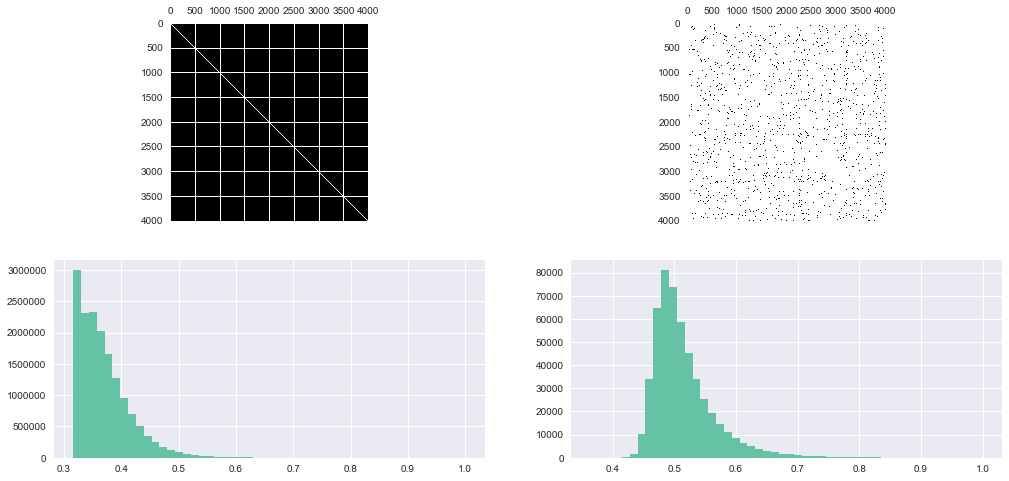

In [22]:
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);

NEIGHBORS = 100
weights = spectral.filter_neighbors(all_weights, NEIGHBORS)

plot(all_weights, axes[:, 0])
plot(weights, axes[:, 1])

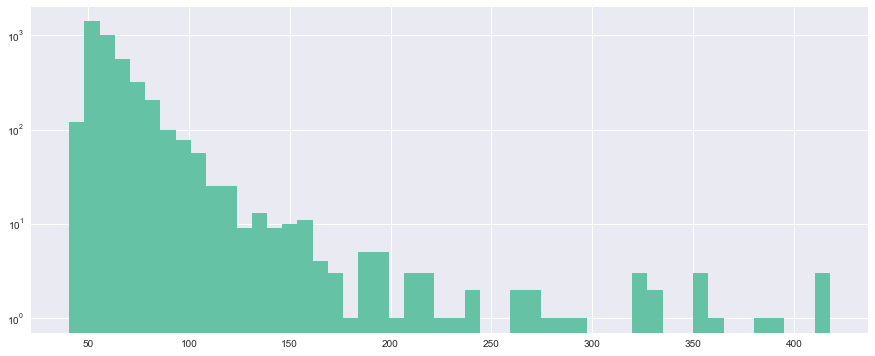

In [23]:
# Weighted degree distribution
degrees = np.sum(weights, axis=0)

plt.hist(degrees, bins=50, log=True);

In [24]:
D = np.diag(degrees)
W = weights
L = D - W

inv_sqrt_D = np.diag(1 / np.diag(D**(0.5)))

normalized_laplacian = inv_sqrt_D @ L @ inv_sqrt_D

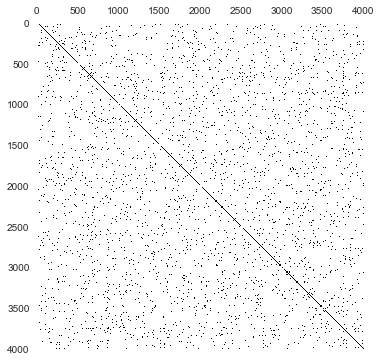

In [25]:
plt.spy(normalized_laplacian);

In [26]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(normalized_laplacian, k=20, which='SM') # which='SA' gives us similar results

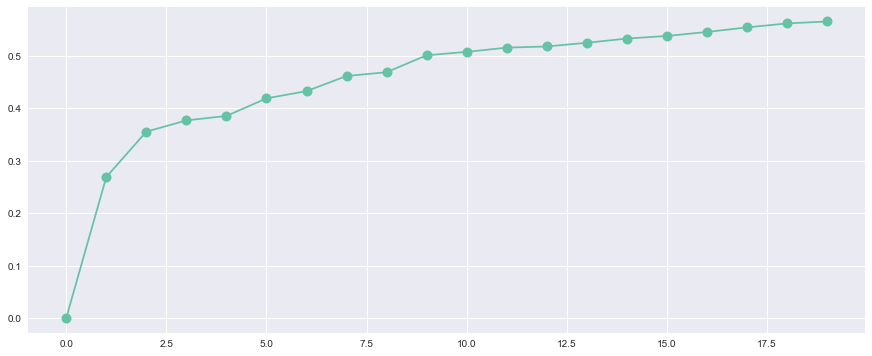

In [27]:
plt.plot(eigenvalues, '.-', markersize=20);

In [28]:
G = nx.from_numpy_matrix(L)
gc = max(nx.connected_component_subgraphs(G), key=len)

In [29]:
assert len(gc.nodes()) == weights.shape[0], "GCC should contain all nodes"

# PCA

In [30]:
features_pca = decomposition.PCA(n_components=3).fit_transform(X)

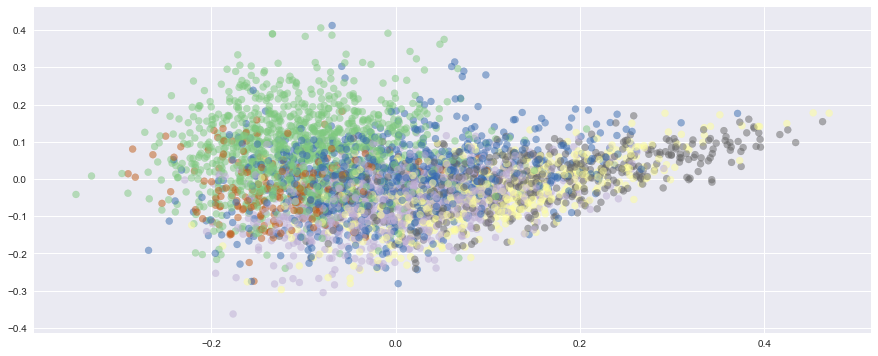

In [31]:
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=y, cmap='Accent', alpha=0.5);

# SPECTRAL

-3623 errors (-90.58%)


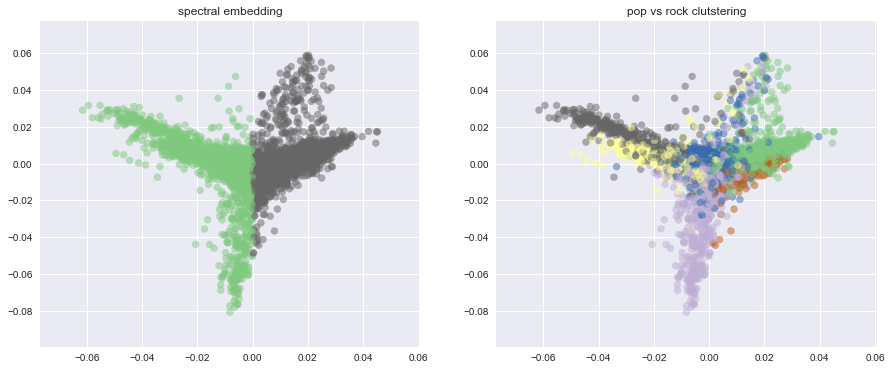

In [32]:
spectral.compare_plot_labels(eigenvectors, y)

# SPECTRAL V2

In [33]:
unsupervised_labels = (eigenvectors[:, 1] - eigenvectors[:, 2]) > 0

In [34]:
accuracy = spectral.compute_err(y, unsupervised_labels)

print('accuracy of {}%'.format(int(accuracy * 10000) / 100))

accuracy of -80.49%


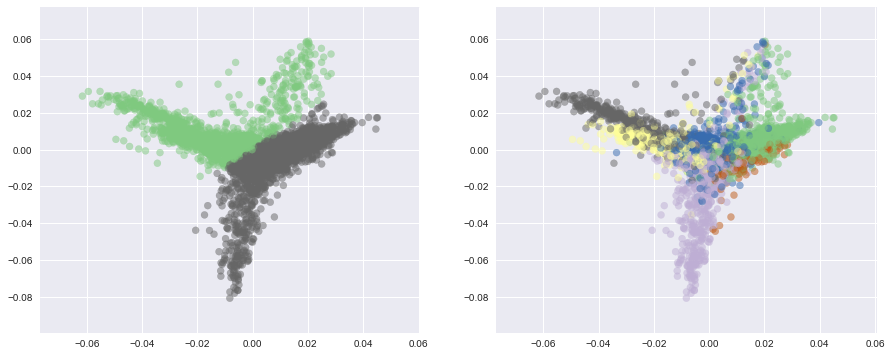

In [35]:
f, axes = plt.subplots(nrows=1, ncols=2)

for ax, lab in zip(axes.flatten(), [unsupervised_labels, y]):
    spectral.plot_labels(eigenvectors, lab, ax=ax)

# 3D

In [36]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

In [37]:
init_notebook_mode(connected=True)
print(__version__)

2.2.2


In [38]:
traces = []

for label in sorted(set(y)):
    label_mask = y == label
    #'''
    axis_x = eigenvectors[:, 1][label_mask]
    axis_y = eigenvectors[:, 2][label_mask]
    axis_z = eigenvectors[:, 3][label_mask]
    '''
    axis_x = features_pca[:, 0][label_mask]
    axis_y = features_pca[:, 1][label_mask]
    axis_z = features_pca[:, 2][label_mask]
    #'''
    trace = go.Scatter3d(
        x=axis_x,
        y=axis_y,
        z=axis_z,
        name=parent_cat[label],
        mode='markers',
        marker=dict(
            size=12,
            color=label,
            #colorscale='Viridis',
            opacity=0.8
        )
    )
    
    traces.append(trace)

In [39]:
layout = go.Layout(
    hovermode= 'closest',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

In [40]:
data = traces

fig = go.Figure(data=data, layout=layout)
iplot(fig)